In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

last date is 2017-08-23
last date is 2016-08-23


Text(0, 0.5, 'Inches')

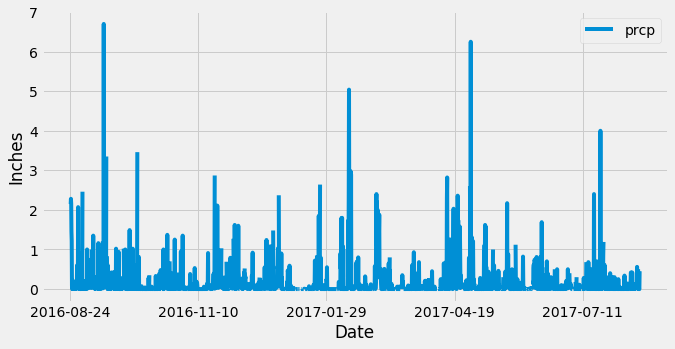

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(func.max(Measurement.date)).scalar()
print(f'last date is {last_date}')
start_date = dt.datetime.strptime(last_date, '%Y-%m-%d').date() - dt.timedelta(days=365)
print(f'last date is {start_date}')

# Perform a query to retrieve the data and precipitation scores
col_selected = [Measurement.date, Measurement.prcp]
prcp_1year = session.query(*col_selected).filter(Measurement.date > start_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_1year).set_index(['date'])
prcp_df
# Sort the dataframe by date
prcp_sorted = prcp_df.sort_index()
prcp_sorted
# Use Pandas Plotting with Matplotlib to plot the data
prcp_chart = prcp_sorted.plot(figsize=(10,5))
prcp_chart.set_xlabel("Date")
prcp_chart.set_ylabel("Inches")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_sorted.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station.station).group_by(Station.station).count()
print(f"number of stations available in the dataset is {station_count}")

number of stations available in the dataset is 9


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_rows = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
station_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = station_rows[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f'the highest temperature is {highest_temp}')
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f'the highest temperature is {lowest_temp}')
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f'the highest temperature is {avg_temp}')

the highest temperature is 85.0
the highest temperature is 54.0
the highest temperature is 71.66378066378067


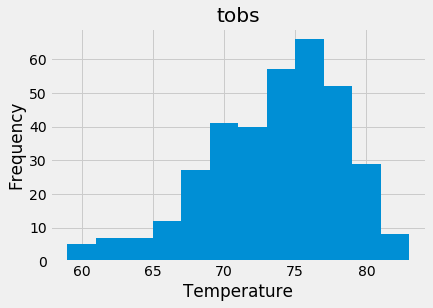

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_selected = [Measurement.date, Measurement.tobs]
tobs_1year = session.query(*tobs_selected).filter(Measurement.date > start_date).\
    filter(Measurement.station == most_active_station).group_by('date').all()
tobs_1year

tobs_df = pd.DataFrame(tobs_1year).set_index('date')
tobs_df

tobs_chart = tobs_df.hist(bins=12)
for ax in tobs_chart.flatten():
    ax.set_xlabel("Temperature")
    ax.set_ylabel("Frequency")


## Bonus Challenge Assignment

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
target_temps = calc_temps('2015-01-03', '2015-01-18')
target_temps

[(56.0, 66.89075630252101, 77.0)]

Text(0, 0.5, 'temp (F)')

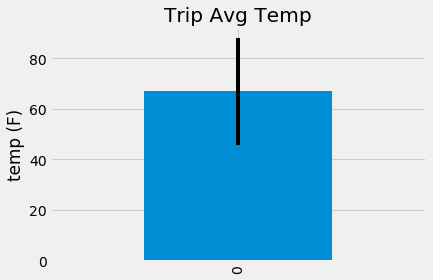

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_err = target_temps[0][2]-target_temps[0][0]
y_value = target_temps[0][1]

y_df = pd.DataFrame({"val":[y_value],"error":[y_err]})
bar_err_plot = y_df["val"].plot(kind='bar',yerr=y_df["error"], title = 'Trip Avg Temp')
bar_err_plot.set_ylabel("temp (F)")

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_col = [Measurement.station, Measurement.prcp]
rain_est_raw = session.query(*rain_col).filter(Measurement.date >= '2014-01-03').\
filter(Measurement.date <= '2014-01-18').all()

rain_est_df = pd.DataFrame(rain_est_raw)

rain_grouped = rain_est_df.groupby(rain_est_df['station']).sum()
rain_sum_df = rain_grouped.reset_index()

station_full = session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation).all()
station_raw = pd.DataFrame(station_full)
station_raw

rain_station = rain_sum_df.merge(station_raw, how = 'left')
rain_station


,station,prcp,name,latitude,longitude,elevation
0,USC00511918,2.07,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
1,USC00513117,3.23,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,1.61,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00516128,3.64,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
4,USC00517948,0.63,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,0.41,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519281,4.49,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00519397,1.83,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,USC00519523,2.58,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normal_list = []
tmin_list = []
tmax_list = []
tavg_list = []
date_list = []
# Set the start and end date of the trip
trip_start_date = '2015-01-03'
trip_end_date = '2015-01-18'
# Use the start and end date to create a range of dates
date_range = pd.date_range(trip_start_date, trip_end_date).tolist()
date_range
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
for item in date_range:
    month_date = '{:%m-%d}'.format(item)
    date_inlist = '{:%Y-%m-%d}'.format(item)
    normal_list.append(daily_normals(month_date)[0])
    tmin_list.append(daily_normals(month_date)[0][0])
    tmax_list.append(daily_normals(month_date)[0][2])
    tavg_list.append(daily_normals(month_date)[0][1])
    date_list.append(date_inlist)
normal_list


[(62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0),
 (57.0, 67.16071428571429, 75.0),
 (58.0, 67.9298245614035, 78.0),
 (62.0, 69.74137931034483, 77.0),
 (57.0, 67.3103448275862, 78.0),
 (57.0, 67.4074074074074, 81.0),
 (57.0, 67.25454545454545, 77.0),
 (58.0, 69.52631578947368, 77.0),
 (56.0, 69.31372549019608, 78.0),
 (54.0, 68.62962962962963, 80.0),
 (61.0, 69.07407407407408, 76.0),
 (57.0, 68.63157894736842, 77.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df = pd.DataFrame(list(zip(tmin_list, tmax_list, tavg_list, date_list)), columns=['tmin', 'tmax','tavg','date'])
normal_final = normal_df.set_index('date')
normal_final

,tmin,tmax,tavg
date,,,
2015-01-03,62.0,77.0,68.909091
2015-01-04,58.0,76.0,70.000000
2015-01-05,56.0,76.0,67.964286
2015-01-06,61.0,76.0,68.964912
2015-01-07,57.0,76.0,68.543860
2015-01-08,57.0,75.0,67.160714
2015-01-09,58.0,78.0,67.929825
2015-01-10,62.0,77.0,69.741379
2015-01-11,57.0,78.0,67.310345


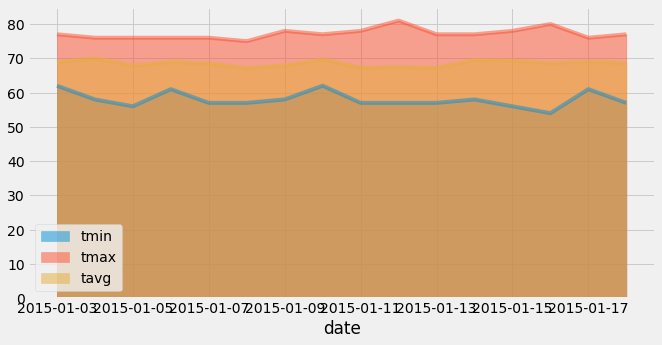

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
ax = normal_final.plot.area(stacked=False, figsize = (10,5))